In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import math

sns.set_style("whitegrid")

In [12]:
st = "2023-01-01"
ed = "2023-12-31"

benchmarkdf = yf.download(tickers="^NSEMDCP50",start=st,end=ed,progress=False,period='1d')
benchmarkdf.drop(columns=["Open","High","Adj Close","Low","Volume"],inplace=True)
benchmarkdf.dropna()
benchmarkdf


Price,Close
Ticker,^NSEMDCP50
Date,
2023-01-02,8821.799805
2023-01-03,8843.349609
2023-01-04,8745.700195
2023-01-05,8808.599609
2023-01-06,8752.299805
...,...
2023-12-22,12838.200195
2023-12-26,12905.599609


In [15]:
initial_investment = 100000
shares_bought = initial_investment/benchmarkdf['Close'].iloc[0]
benchmarkdf['Portfolio Value'] = benchmarkdf['Close']*shares_bought
benchmarkdf

Price,Close,Portfolio Value
Ticker,^NSEMDCP50,
Date,,
2023-01-02,8821.799805,100000.000000
2023-01-03,8843.349609,100244.279004
2023-01-04,8745.700195,99137.368666
2023-01-05,8808.599609,99850.368455
2023-01-06,8752.299805,99212.178903
...,...,...
2023-12-22,12838.200195,145528.128948
2023-12-26,12905.599609,146292.138737


In [18]:
final_portfolio_value = benchmarkdf['Portfolio Value'].iloc[-1]
benchmark_returns = (final_portfolio_value-initial_investment)*100/initial_investment
print("Benchmark returns: ",round(benchmark_returns,2),"%")
 
s=benchmarkdf['Portfolio Value']
s=np.log(s/s.shift(1))
s=s[1:]
sigma = np.std(s)*math.sqrt(252)
s=s.mean()*252
print("Risk: ",sigma)
ra =s
rb = 0.07
benchmark_sharpe_ratio = (ra-rb)/sigma
print("Benchmark Sharpe Ratio: ",round(benchmark_sharpe_ratio,2))

Benchmark returns:  49.01 %
Risk:  0.12340268141198116
Benchmark Sharpe Ratio:  2.77


<Axes: xlabel='Date'>

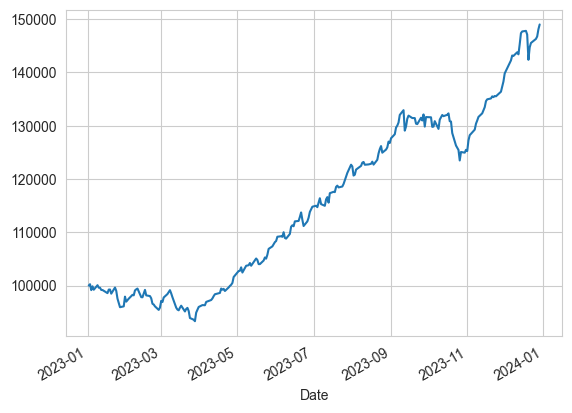

In [20]:
benchmarkdf['Portfolio Value'].plot(kind='line')

In [46]:
NUM_SIMULATIONS = 10000
NUM_DAYS = 252

stocks=["LUPIN.NS","VOLTAS.NS","NMDC.NS","ZYDUSLIFE.NS","SAIL.NS"]

from itertools import combinations
numbers = range(len(stocks))
combs = list(combinations(numbers,3))

for comb in combs:
    stocks_new = [stocks[i] for i in comb]
    stock_data ={}
    for stock in stocks_new:
        ticker = yf.Ticker(stock)
        stock_data[stock] = ticker.history(start = st,end=ed)['Close']
    stock_prices = pd.DataFrame(stock_data)

    log_returns = np.log(stock_prices/stock_prices.shift(1))
    log_returns = log_returns.dropna()

    portfolio_weights=[]
    portfolio_returns=[]
    portfolio_risks=[]

    for i in range(NUM_SIMULATIONS):

        w = np.random.random(3)
        w=w/np.sum(w)
        portfolio_weights.append(w)
        port_returns = np.sum(log_returns.mean()*w)*NUM_DAYS
        portfolio_returns.append(port_returns)
        port_risks= np.sqrt(np.dot(w.T,np.dot(log_returns.cov()*NUM_DAYS,w)))
        portfolio_risks.append(port_risks)

    risk_free_rate=0.07
    portfolio_weights=np.array(portfolio_weights)
    portfolio_returns=np.array(portfolio_returns)
    portfolio_risks=np.array(portfolio_risks)

    sharpe_ratios = (portfolio_returns-risk_free_rate)/portfolio_risks

    portfolios = pd.DataFrame({"Returns": portfolio_returns,"Risk":portfolio_risks,"Sharpe": sharpe_ratios})

    ind=0

    for i in range(len(sharpe_ratios)):
        if(sharpe_ratios[i]==np.amax(sharpe_ratios)):
            ind=i

    weights=  portfolio_weights[ind]

    shares=[]
    df=stock_prices.copy()

    shares = initial_investment*weights/stock_prices.iloc[0]

    daily_portfolio_value = (stock_prices*shares).sum(axis=1)

    df['Portfolio Value'] = daily_portfolio_value

    final_portfolio_value = df['Portfolio Value'].iloc[-1]

    df_returns = (final_portfolio_value-initial_investment)*100/initial_investment
    print("Using stocks: ", stocks_new)
    print("Stock returns: ",round(df_returns,2),"%")

    df_sr =sharpe_ratios[ind]
    print("Stock risk:" ,portfolio_risks[ind])

    print("Stock sharpe ratio: ",round(df_sr,2))
    print()

Using stocks:  ['LUPIN.NS', 'VOLTAS.NS', 'NMDC.NS']
Stock returns:  73.72 %
Stock risk: 0.1900928518894159
Stock sharpe ratio:  2.6

Using stocks:  ['LUPIN.NS', 'VOLTAS.NS', 'ZYDUSLIFE.NS']
Stock returns:  69.95 %
Stock risk: 0.1857911997350593
Stock sharpe ratio:  2.54

Using stocks:  ['LUPIN.NS', 'VOLTAS.NS', 'SAIL.NS']
Stock returns:  68.32 %
Stock risk: 0.19930640331484134
Stock sharpe ratio:  2.3

Using stocks:  ['LUPIN.NS', 'NMDC.NS', 'ZYDUSLIFE.NS']
Stock returns:  74.52 %
Stock risk: 0.17755199064960941
Stock sharpe ratio:  2.84

Using stocks:  ['LUPIN.NS', 'NMDC.NS', 'SAIL.NS']
Stock returns:  79.1 %
Stock risk: 0.20580720361551139
Stock sharpe ratio:  2.58

Using stocks:  ['LUPIN.NS', 'ZYDUSLIFE.NS', 'SAIL.NS']
Stock returns:  71.33 %
Stock risk: 0.1891455882514082
Stock sharpe ratio:  2.56

Using stocks:  ['VOLTAS.NS', 'NMDC.NS', 'ZYDUSLIFE.NS']
Stock returns:  67.57 %
Stock risk: 0.1774595833930233
Stock sharpe ratio:  2.59

Using stocks:  ['VOLTAS.NS', 'NMDC.NS', 'SAIL.NS'